In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import sys
from importlib import reload
from pathlib import Path
import scanpy as sc
from pylab import rcParams
from matplotlib.patches import Patch
import re
import seaborn as sns
import glob

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import scvelo as scv
scv.logging.print_version()


scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.set_figure_params('scvelo')  # for beautified visualization

%matplotlib inline

Running scvelo 0.2.2 (python 3.8.3) on 2021-02-19 12:03.


In [2]:
def adata_louvain_name_convert(inputAdata, orderDf, louvainNewOrdered, louvainOldOrdered):
    inputAdata.obs["louvain_celltype"] = ["%s_%s"%(x,y) for index, (x,y) in enumerate(zip(inputAdata.obs['louvain'], inputAdata.obs['cell_type']))]
    inputAdata.obs["celltype_general"] = [x[0] for x in inputAdata.obs['cell_type']]
    
    #--- Match old & new louvain levels
    inputAdata.obs['louvain_old'] = inputAdata.obs['louvain']
    inputAdata.uns['louvain_old_colors'] = inputAdata.uns['louvain_colors']
    inputAdata.obs['louvain'] = [ louvainNewOrdered[louvainOldOrdered.index(int(x))] for x in inputAdata.obs['louvain'] ]
    category_order = orderDf.sort_values('louvain')['louvain_new_label'].tolist()
    category_order = [x for x in category_order if x in np.unique(inputAdata.obs['louvain'])]
    inputAdata.obs['louvain'] = pd.Categorical(inputAdata.obs['louvain'].tolist(), categories=category_order) # The key is to set categories according to original order...

    inputAdata.obs['Infection type'] = [ 'Armstrong' if 'A' in x else 'Clone13' if 'C' in x else 'Naive' for x in inputAdata.obs['cell_type']]
    inputAdata.obs['cell_id'] = inputAdata.obs.index.tolist()

In [3]:
###----- Get dir & load / reload packages
try:
    code_dir
except NameError:
    print("Start")
    code_dir = os.getcwd()
    base_dir = code_dir.replace("/plotting_codes","")
    tools_dir = base_dir + "/tools"

    sys.path.insert(1, tools_dir)
    import sc_addons
    import sc_pl_addons
else:
    print("Reload")
    reload(sc_addons)
    reload(sc_pl_addons)

Start


In [4]:
## ----- Setup working dir
sp_name = "0_Acute-Chronic"
analysis_name = ["0", "resampled"] 

wk_dir = base_dir + "/9_Figures/%s/%s_%s/scVelo"%(sp_name, analysis_name[0], analysis_name[1])
Path(wk_dir).mkdir(parents=True, exist_ok=True)
os.chdir(wk_dir)

print(sp_name)

0_Acute-Chronic


In [5]:
###----- old - new cluster names
order_file ='%s/%s/2_scVelo'%(base_dir, sp_name) + '/%s_scVelo_out_%sNoDyn/pt_ordered_cluster_avg.csv'%(analysis_name[0], analysis_name[1])
order_df = pd.read_csv(order_file)
louvain_new_ordered = order_df['louvain_new_label'].tolist()
louvain_old_ordered = order_df['louvain'].tolist()

In [6]:
resampled_h5ad = '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/0_Acute-Chronic/2_scVelo/0_scVelo_out_resampledNoDyn/0_Acute-Chronic_scVelo_postPT.h5ad'
adata = scv.read(resampled_h5ad)

act_h5ad = '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/0_Acute-Chronic/2_scVelo/1_scVelo_out_ACTonlyNoDyn/0_Acute-Chronic_scVelo_postPT.h5ad'
adata_act = scv.read(act_h5ad)

act_arm_h5ad = '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/0_Acute-Chronic/2_scVelo/2_scVelo_out_actARMonlyNoDyn/0_Acute-Chronic_scVelo_postPT.h5ad'
adata_act_arm = scv.read(act_arm_h5ad)

act_cl13_h5ad = '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/0_Acute-Chronic/2_scVelo/3_scVelo_out_actCL13onlyNoDyn/0_Acute-Chronic_scVelo_postPT.h5ad'
adata_act_cl13 = scv.read(act_cl13_h5ad)

arm_h5ad = '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/0_Acute-Chronic/2_scVelo/2_scVelo_out_ARMonlyNoDyn/0_Acute-Chronic_scVelo_postPT.h5ad'
adata_arm = scv.read(arm_h5ad)

cl13_h5ad = '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/0_Acute-Chronic/2_scVelo/3_scVelo_out_CL13onlyNoDyn/0_Acute-Chronic_scVelo_postPT.h5ad'
adata_cl13 = scv.read(cl13_h5ad)

adata_louvain_name_convert(adata, order_df, louvain_new_ordered, louvain_old_ordered)
adata_louvain_name_convert(adata_act, order_df, louvain_new_ordered, louvain_old_ordered)
adata_louvain_name_convert(adata_act_arm, order_df, louvain_new_ordered, louvain_old_ordered)
adata_louvain_name_convert(adata_act_cl13, order_df, louvain_new_ordered, louvain_old_ordered)
adata_louvain_name_convert(adata_arm, order_df, louvain_new_ordered, louvain_old_ordered)
adata_louvain_name_convert(adata_cl13, order_df, louvain_new_ordered, louvain_old_ordered)

adata_act.obs['velocity_pseudotime'] = adata.obs['velocity_pseudotime'][adata_act.obs.index.tolist()]
adata_act_arm.obs['velocity_pseudotime'] = adata.obs['velocity_pseudotime'][adata_act_arm.obs.index.tolist()]
adata_act_cl13.obs['velocity_pseudotime'] = adata.obs['velocity_pseudotime'][adata_act_cl13.obs.index.tolist()]
adata_arm.obs['velocity_pseudotime'] = adata.obs['velocity_pseudotime'][adata_arm.obs.index.tolist()]
adata_cl13.obs['velocity_pseudotime'] = adata.obs['velocity_pseudotime'][adata_cl13.obs.index.tolist()]

In [7]:
paga_xmax, paga_ymax = np.amax(adata.obsm['paga'], axis=0)
paga_xmin, paga_ymin = np.amin(adata.obsm['paga'], axis=0)
paga_dx, paga_dy = paga_xmax - paga_xmin, paga_ymax - paga_ymin
paga_xmax, paga_xmin = paga_xmax + paga_dx*0.1, paga_xmin - paga_dx*0.1
paga_ymax, paga_ymin = paga_ymax + paga_dy*0.1, paga_ymin - paga_dy*0.1

In [8]:
# Calculate radius of louvain cluster circles
nodeplot_size_col_df = pd.DataFrame()
nodeplot_size_col_df['colors'] = adata.uns['louvain_colors'].tolist()
nodeplot_size_col_df.index = adata.obs['louvain'].cat.categories.tolist()
nodeplot_size_col_df.index.name = 'louvain'
#--- all
size_series = adata.obs.groupby('louvain').count()['cell_type']
nodeplot_size_col_df['all'] = size_series
#--- Act
size_series = adata_act.obs.groupby('louvain').count()['cell_type']
nodeplot_size_col_df['act'] = size_series
#--- Act Arm
size_series = adata_act_arm.obs.groupby('louvain').count()['cell_type']
nodeplot_size_col_df['act_Arm'] = size_series
#--- Act Cl13
size_series = adata_act_cl13.obs.groupby('louvain').count()['cell_type']
nodeplot_size_col_df['act_Cl13'] = size_series
#--- Arm
size_series = adata_arm.obs.groupby('louvain').count()['cell_type']
nodeplot_size_col_df['Arm'] = size_series
#--- Cl13
size_series = adata_cl13.obs.groupby('louvain').count()['cell_type']
nodeplot_size_col_df['Cl13'] = size_series

nodeplot_size_col_df = nodeplot_size_col_df.loc[louvain_new_ordered]
nodeplot_size_col_df.to_csv('/media/pipkin/ROCKET-PRO/CD8_DEV_SC/9_Figures/0_Acute-Chronic/nodeplot_size_color.csv')

In [127]:
def avg_v_u(driver_genes, adata_use):
    driver_genes = [x for x in driver_genes if x in adata_act_arm.var.index.tolist()]
    
    ###----- Get original dfs
    velocity_df = pd.DataFrame(adata_use.layers['velocity'])
    velocity_df.index = adata_use.obs.index
    velocity_df.columns = adata_use.var.index

    expr_u_df = pd.DataFrame(adata_use.layers['Mu']) #pd.DataFrame.sparse.from_spmatrix(adata_use.X).sparse.to_dense()
    expr_u_df.index = adata_use.obs.index
    expr_u_df.columns = adata_use.var.index
    
    expr_s_df = pd.DataFrame(adata_use.layers['Ms']) #pd.DataFrame.sparse.from_spmatrix(adata_use.X).sparse.to_dense()
    expr_s_df.index = adata_use.obs.index
    expr_s_df.columns = adata_use.var.index
    
    # Select genes to use
    velocity_df = velocity_df[driver_genes]
    expr_u_df = expr_u_df[driver_genes]
    expr_s_df = expr_s_df[driver_genes]
    
    # Calculate average
    v_avg_df = pd.DataFrame(index=louvain_new_ordered)
    u_avg_df = pd.DataFrame(index=louvain_new_ordered)
    s_avg_df = pd.DataFrame(index=louvain_new_ordered)
    
    velocity_df['louvain'] = adata_use.obs['louvain'].tolist()
    expr_u_df['louvain'] = adata_use.obs['louvain'].tolist()
    expr_s_df['louvain'] = adata_use.obs['louvain'].tolist()
    
    v_avg_df = velocity_df.groupby('louvain').mean()
    u_avg_df = expr_u_df.groupby('louvain').mean()
    s_avg_df = expr_s_df.groupby('louvain').mean()
    
    #e_z_df = e_avg_df.copy()
    #for col in e_z_df.columns:
    #    e_z_df[col] = (e_z_df[col] - e_z_df[col].mean())/e_z_df[col].std(ddof=0)
        
    return(v_avg_df, u_avg_df, s_avg_df) #, e_z_df

## Velocity embedding stream

In [128]:
il2_stat5_promoted = pd.read_csv('/media/pipkin/ROCKET-PRO/CD8_DEV_SC/9_Figures/9_Meta/Il2-stat5_direct_promote.csv')['gene_name'].tolist()

In [129]:
all_genes = adata_act_arm.var.index.tolist()
arm_v_avg_df, arm_u_avg_df, arm_s_avg_df = avg_v_u(all_genes, adata_act_arm)
cl13_v_avg_df, cl13_u_avg_df, cl13_s_avg_df = avg_v_u(all_genes, adata_act_cl13)

In [153]:
out_df_name = base_dir + '/9_Figures/0_Acute-Chronic/0_resampled/arm_cl13_LouvainAvg_velocity.csv'

arm_v_avg_df_slt = arm_v_avg_df.loc[["P2","P3","P4","P5","P6","P7","P8","P9","P10"]].T
arm_v_avg_df_slt.columns = ["%s_Arm"%x for x in arm_v_avg_df_slt.columns]
cl13_v_avg_df_slt = cl13_v_avg_df.loc[["P2","P3","P4","P5","P6","P7","P8","P9","P10"]].T
cl13_v_avg_df_slt.columns = ["%s_Cl13"%x for x in cl13_v_avg_df_slt.columns]
arm_cl13_v_avg_df_slt = arm_v_avg_df_slt.join(cl13_v_avg_df_slt)
arm_cl13_v_avg_df_slt.index.name = 'gene_name'

arm_cl13_v_avg_df_slt.to_csv(out_df_name)

In [156]:
out_df_name = base_dir + '/9_Figures/0_Acute-Chronic/0_resampled/arm_cl13_LouvainAvg_unspliced.csv'

arm_u_avg_df_slt = arm_u_avg_df.loc[["P2","P3","P4","P5","P6","P7","P8","P9","P10"]].T
arm_u_avg_df_slt.columns = ["%s_Arm"%x for x in arm_u_avg_df_slt.columns]
cl13_u_avg_df_slt = cl13_u_avg_df.loc[["P2","P3","P4","P5","P6","P7","P8","P9","P10"]].T
cl13_u_avg_df_slt.columns = ["%s_Cl13"%x for x in cl13_u_avg_df_slt.columns]
arm_cl13_u_avg_df_slt = arm_u_avg_df_slt.join(cl13_u_avg_df_slt)
arm_cl13_u_avg_df_slt.index.name = 'gene_name'

arm_cl13_u_avg_df_slt.to_csv(out_df_name)

In [157]:
out_df_name = base_dir + '/9_Figures/0_Acute-Chronic/0_resampled/arm_cl13_LouvainAvg_spliced.csv'

arm_s_avg_df_slt = arm_s_avg_df.loc[["P2","P3","P4","P5","P6","P7","P8","P9","P10"]].T
arm_s_avg_df_slt.columns = ["%s_Arm"%x for x in arm_s_avg_df_slt.columns]
cl13_s_avg_df_slt = cl13_s_avg_df.loc[["P2","P3","P4","P5","P6","P7","P8","P9","P10"]].T
cl13_s_avg_df_slt.columns = ["%s_Cl13"%x for x in cl13_s_avg_df_slt.columns]
arm_cl13_s_avg_df_slt = arm_s_avg_df_slt.join(cl13_s_avg_df_slt)
arm_cl13_s_avg_df_slt.index.name = 'gene_name'

arm_cl13_s_avg_df_slt.to_csv(out_df_name)

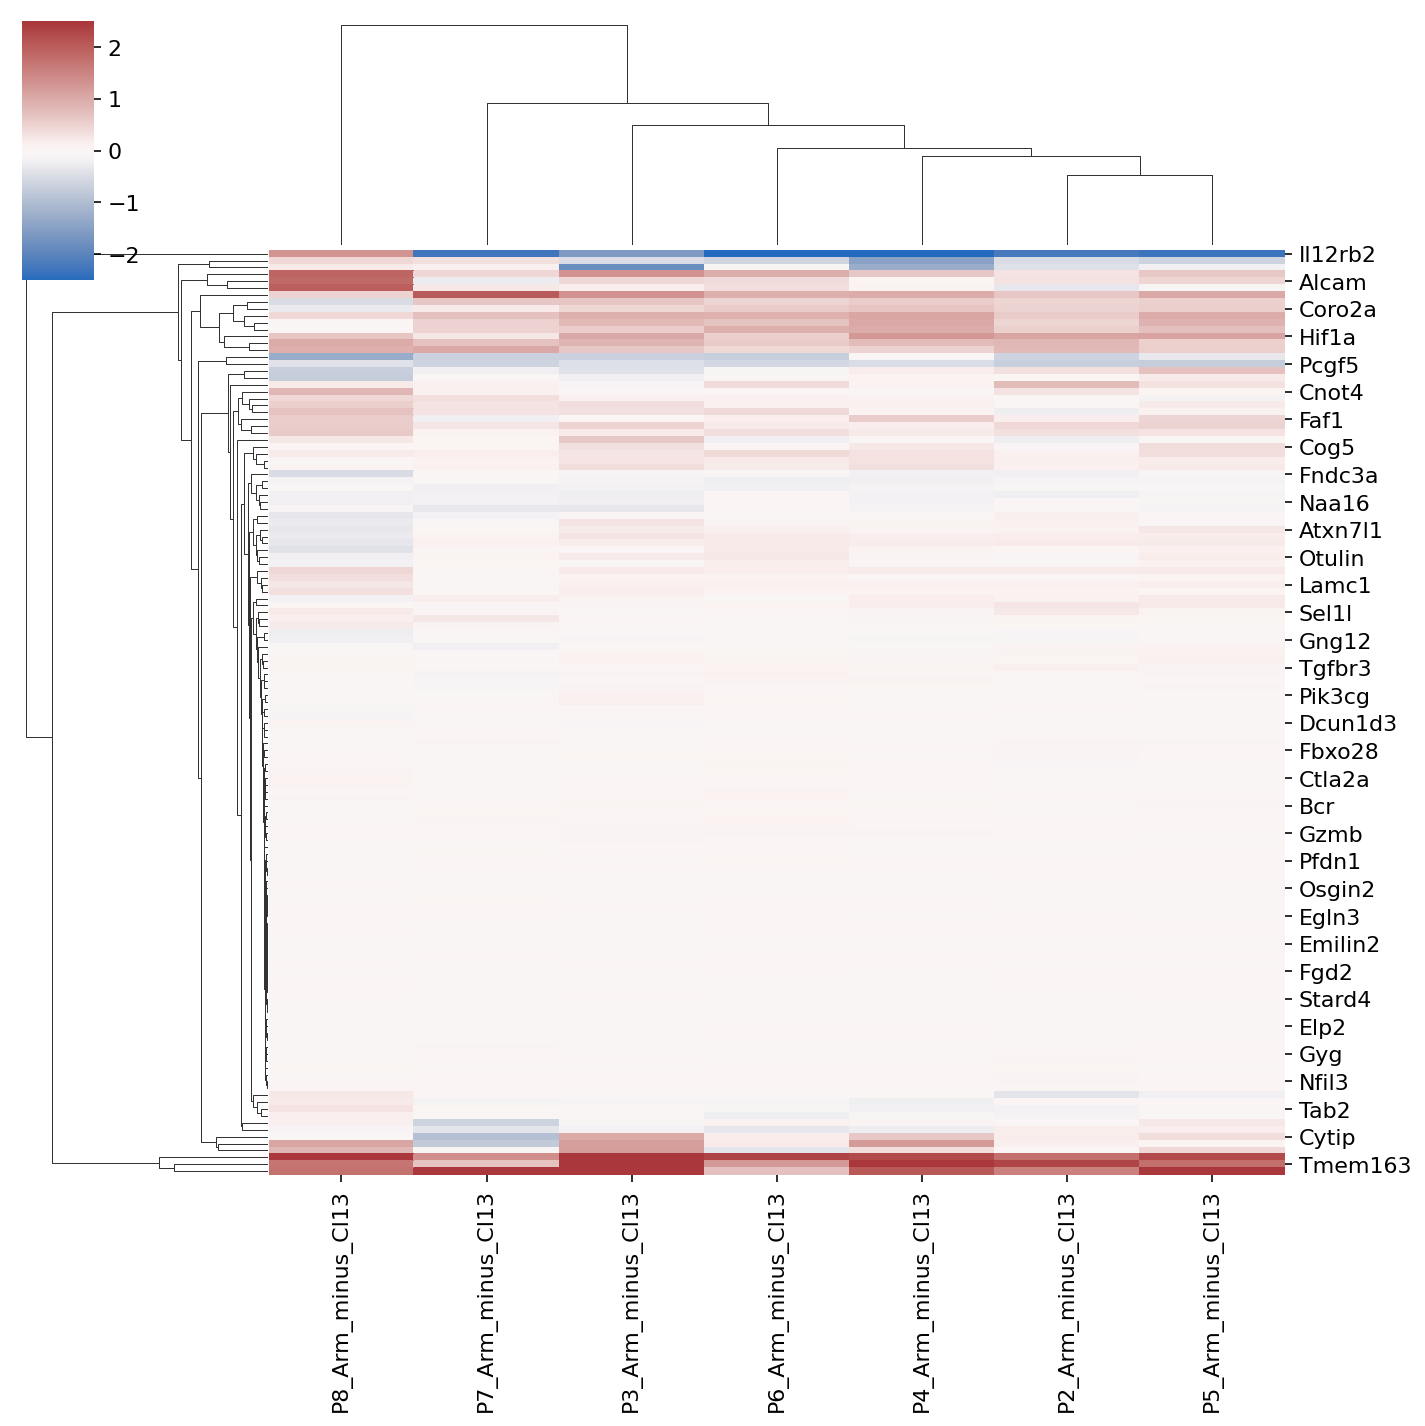

In [158]:
sns.clustermap(arm_minus_cl13_v_df, cmap="vlag",  vmin=-2.5, vmax=2.5)